In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, e, m_p

%matplotlib inline
import seaborn as sns
sns.set_context('notebook', font_scale=1.5)
sns.set_style('darkgrid', {
        'axes.linewidth': 2,
        'axes.labelcolor': 'w',
        'lines.markeredgewidth': 0,
        'legend.fancybox': True})

## Bunch creation

We create a bunch - LHC type. No fancy wrapper function available yet to produce a RF matched distribution. A little tedious because it requires quite some definitions to be done beforehand of the full RF System - but that's due to the nature of the problem.

- Some beam kinetic parameters and RF machine parameters

In [12]:
from PyHEADTAIL.trackers.rf_bucket import RFBucket
from PyHEADTAIL.particles.generators import ParticleGenerator, \
    gaussian2D, RF_bucket_distribution, StationaryExponential

In [13]:
momentum = 450e9 * e/c
gamma = np.sqrt((momentum/(m_p*c))**2 + 1)
beta = np.sqrt(1 - gamma**-2)

circumference = 26658.883
alpha = 3.225e-4
h1 = 35640
V1 = 8e6
p_increment = 0 * e/c * circumference/(beta*c)

print gamma

479.606062093


In [26]:
rfbucket = RFBucket(
    charge=e, mass=m_p, gamma=gamma,
    circumference=circumference,
    alpha_array=[alpha], p_increment=0,
    harmonic_list=[h1], voltage_list=[V1], phi_offset_list=[0])

In [27]:
dt = (0, 2.5e-9, 7.5e-9)
epsn_z = (0.35, 0.25, 0.1)

In [28]:
bunches = [
    ParticleGenerator(
        macroparticlenumber=1e5, intensity=1e11,
        charge=e, mass=m_p, gamma=gamma,
        circumference=26658.883,
        distribution_x=gaussian2D(2e-6),
        distribution_y=gaussian2D(2e-6),
        distribution_z=RF_bucket_distribution(rfbucket, epsn_z=epsn_z[i])
    ).generate() for i in xrange(3)]

*** Maximum RMS emittance 0.888689919173eV s.
... distance to target emittance: 2.32e-02
... distance to target emittance: 2.34e-02
... distance to target emittance: -5.11e-04
... distance to target emittance: 1.04e-05
--> Emittance: 0.350000004218
--> Bunch length:0.0697492609648
*** Maximum RMS emittance 0.888689919173eV s.
... distance to target emittance: 1.69e-02
... distance to target emittance: 1.70e-02
... distance to target emittance: -4.02e-05
--> Emittance: 0.250000069118
--> Bunch length:0.0580813886211
*** Maximum RMS emittance 0.888689919173eV s.
... distance to target emittance: 2.45e-03
... distance to target emittance: 2.57e-03
... distance to target emittance: 1.73e-06
--> Emittance: 0.100000001214
--> Bunch length:0.0359672667212


In [29]:
for i, b in enumerate(bunches):
    b.z -= dt[i] * (b.beta*c)

bunch1, bunch2, bunch3 = bunches
allbunches = sum(bunches)

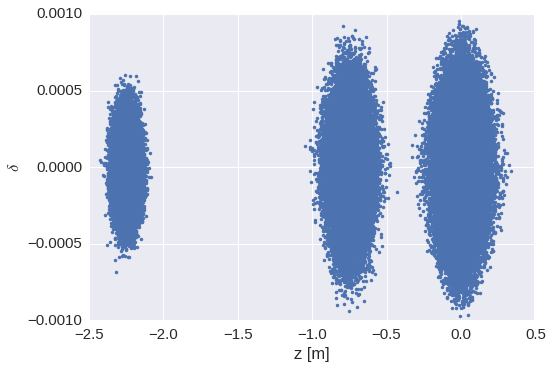

In [30]:
# fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(6,6))
# ax1.plot(bunch.x, bunch.xp, '.')
# ax2.plot(bunch.y, bunch.yp, '.')
# ax3.plot(bunch.z, bunch.dp, '.')
# ax3.set_ylim(-max(abs(bunch.dp))-1e-4, max(abs(bunch.dp))+1e-4)
# plt.show()

plt.plot(allbunches.z, allbunches.dp, '.')
plt.xlabel("z [m]")
plt.ylabel(r"$\delta$")
plt.show()

## Wakes, slicing, convolution etc.

The CircularResonator wake is a special resonator wake with Yokoya factors X1=1, Y1=1, X2=0, Y2=0

functions transverse and longitudinal are actually meant to be used internally when building the wake kicks - at this point they are concatenated with the respective Yokoya factor being applied/provided. For visualisation we can also build them externally manually.

In [31]:
from PyHEADTAIL.impedances.wakes import CircularResonator, \
    WakeField, check_wake_sampling
from PyHEADTAIL.particles.slicing import UniformBinSlicer

In [34]:
wake = CircularResonator(R_shunt=1e9, frequency=1e9, Q=20)
slicer = UniformBinSlicer(60, z_cuts=(-.3, .3))

wakefields = WakeField(slicer, wake)
kick = wakefields.wake_kicks[0]
wf = kick.wake_function

slices, times = [], []
for i, b in enumerate(bunches):
    distance = dt[i]*b.beta*c
    b.z += distance
    slices.append(b.get_slices(slicer))
    times.append(slices[-1].z_centers / (b.beta*c))
    b.z -= distance

slices1, slices2, slices3 = slices
times1, times2, times3 = times

*** PyHEADTAIL WARNING! Acceleration not handled properly by this kind of convolution due to changing bunch length!
*** PyHEADTAIL WARNING! Acceleration not handled properly by this kind of convolution due to changing bunch length!


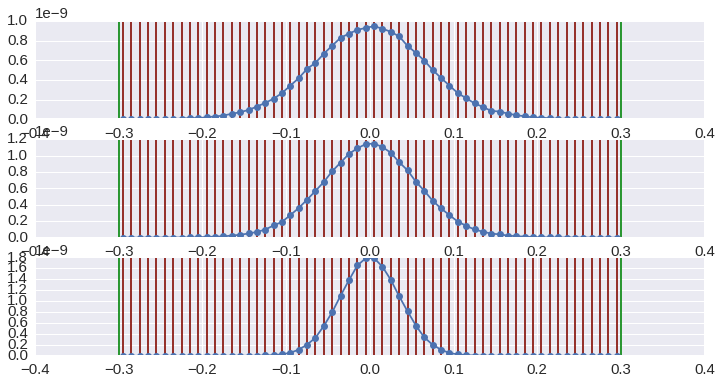

In [35]:
col = sns.hls_palette(6, l=.3, s=.8)

fig, axes = plt.subplots(len(slices), figsize=(12,6))

for i, ax in enumerate(axes):
    [ax.axvline(s, c=col[0]) for s in slices[i].z_centers]
    [ax.axvline(s, c=col[2]) for s in [slices[i].z_cut_tail, slices[i].z_cut_head]]
    ax.plot(slices[i].z_centers, slices[i].charge_per_slice, '-o')
    ax.set_xlim(-.4, .4)

plt.show()

## Convolutions

### Separate bunches

In [43]:
delta_xp = []
for i, s in enumerate(slices):
    dxp = 0.*times[i]
    t_target = times[i]
    s_target = slices[i]
    for j in range(i+1):
        t_source = times[j] + dt[j-i]
        s_source = slices[j]
        print i, j, dt[i-j]
        for k in range(s_target.n_slices):
            for l in range(s_source.n_slices)[::+1]:
                dxp[k] += s_source.charge_per_slice[l]*wf(
                    t_target[k]-t_source[l])
    delta_xp.append(dxp)
    
delta_xp1 = np.array(delta_xp).copy()

0 0 0
1 0 2.5e-09
1 1 0
2 0 7.5e-09
2 1 2.5e-09
2 2 0


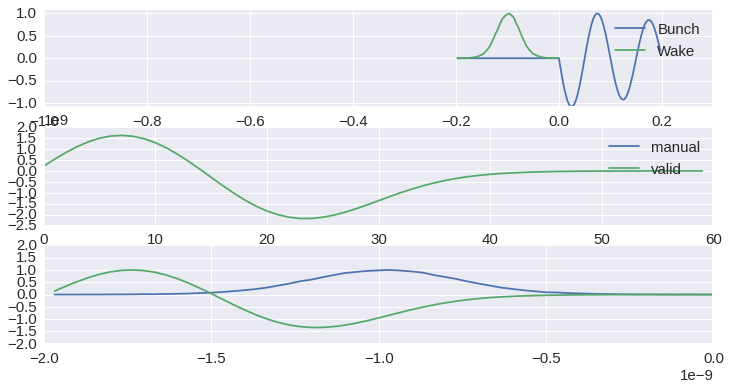

1 0 2.5e-09


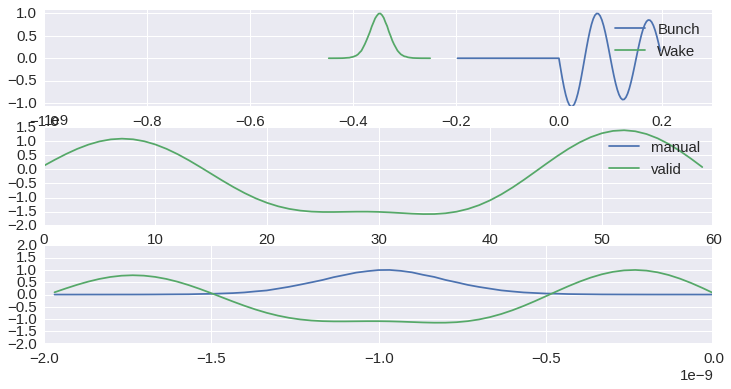

2 0 7.5e-09
2 1 2.5e-09


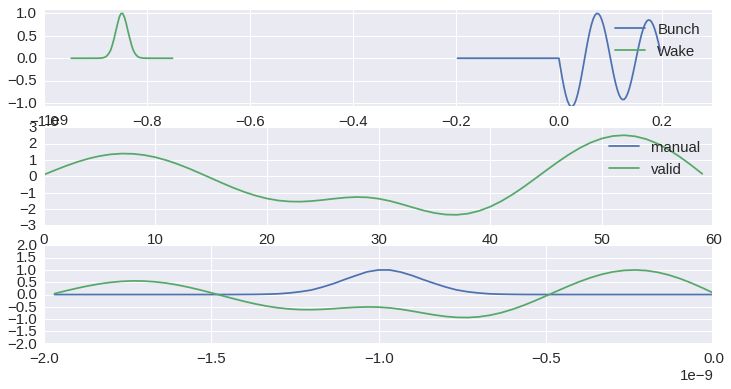

In [56]:
# tt = times - times[0]
# tt = np.concatenate((-tt[::-1], tt[1:]))

dxp_list = []
for i, s in enumerate(slices):
    dts = times[i]
    t0 = np.concatenate((dts-dts[-1], (dts-dts[0])[1:]))

    dxp = np.convolve(s.charge_per_slice, wf(t0))
    dxp_s = np.convolve(s.charge_per_slice, wf(t0), mode='same')
    dxp_v = np.convolve(s.charge_per_slice, wf(t0), mode='valid')

    for j in range(i):
        print i, j, dt[i-j]
        t_sources = times[j] + dt[i-j]
        t2 = np.concatenate((dts-t_sources[-1], (dts-t_sources[0])[1:]))

        dxp += np.convolve(slices[j].charge_per_slice, wf(t2))
        dxp_s += np.convolve(slices[j].charge_per_slice, wf(t2), mode='same')
        dxp_v += np.convolve(slices[j].charge_per_slice, wf(t2), mode='valid')
    
    dxp_list.append(dxp_v)

    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,6))
#     fig.patch.set_color("#848482")

    ax1.plot(t0, wf(t0)[::-1]/max(wf(t0)[::-1]))
    ax1.plot(dts-dts[-1]-dt[i], s.charge_per_slice/max(s.charge_per_slice))
    ax1.set_ylim((-1.1, 1.1))
    ax1.legend(['Bunch', 'Wake'])
    ax1.set_xlim(-10e-9, 3e-9)
    ax2.plot(delta_xp[i])
    ax2.plot(dxp_v)
    ax2.legend(['manual', 'valid'])
    ax3.plot(dts-dts[-1], s.charge_per_slice/max(s.charge_per_slice))
    ax3.plot(dts-dts[-1], dxp_v/max(dxp_v))
    ax3.set_ylim(-2, 2)

    plt.show()

### All bunches

In [45]:
allslicer = UniformBinSlicer(400, z_cuts=(-3, .5))
allslices = allbunches.get_slices(allslicer)

alltimes = allslices.z_centers / (allbunches.beta*c)

In [46]:
delta_xp = 0.*alltimes
for i, s in enumerate(allslices.charge_per_slice):
    for j in range(allslices.n_slices)[::+1]:
        delta_xp[i] += allslices.charge_per_slice[j]*wf(alltimes[i]-alltimes[j])

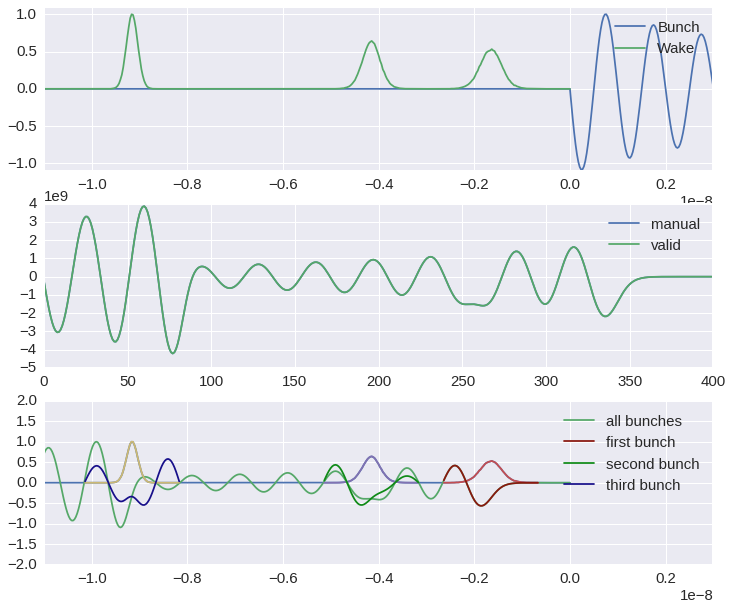

In [47]:
t0 = np.concatenate((alltimes-alltimes[-1],
                    (alltimes-alltimes[0])[1:]))

dxp = np.convolve(allslices.charge_per_slice, wf(t0))
dxp_s = np.convolve(allslices.charge_per_slice, wf(t0), mode='same')
dxp_v = np.convolve(allslices.charge_per_slice, wf(t0), mode='valid')

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12,10))

ax1.plot(t0, wf(t0)[::-1]/max(wf(t0)[::-1]))
ax1.plot(alltimes-alltimes[-1],
         allslices.charge_per_slice/max(allslices.charge_per_slice))
ax1.set_ylim((-1.1, 1.1))
ax1.legend(['Bunch', 'Wake'])
ax1.set_xlim(-11e-9, 3e-9)
ax2.plot(delta_xp)
ax2.plot(dxp_v)
ax2.legend(['manual', 'valid'])

ax3.plot(alltimes-alltimes[-1],
         allslices.charge_per_slice/max(allslices.charge_per_slice))
ax3.plot(alltimes-alltimes[-1], dxp_v/max(dxp_v), label="all bunches")

labels = ["first bunch", "second bunch", "third bunch"]
scale_kick = max([max(x) for x in dxp_list])
scale_charge = max([max(s.charge_per_slice) for s in slices])
for i, s in enumerate(slices):
    dts = times[i]
    dxp = dxp_list[i]
    dxp = delta_xp1[i]
    ax3.plot(dts-alltimes[-1]-dt[i], s.charge_per_slice/scale_charge)
    if i==2:
#         ax3.plot(dts-alltimes[-1]-dt[i], dxp/scale_kick, label=labels[i], c=col[i*2])
        ax3.plot(dts-alltimes[-1]-dt[i], dxp/max(dxp_v), label=labels[i], c=col[i*2])
    else:
        ax3.plot(dts-alltimes[-1]-dt[i], dxp/max(dxp_v), label=labels[i], c=col[i*2])

# ax3.plot(times-times[-1]-dt, slices2.charge_per_slice/max(slices2.charge_per_slice))
# ax3.plot(times-times[-1]-dt, dxp_v2/max(dxp_v), label="second bunch")

ax3.legend()
ax3.set_xlim(-11e-9, 3e-9)
ax3.set_ylim(-2, 2)

# c = sns.color_palette('husl', 3)
# [ax3.axvline(s, c=c[0], alpha=0.8) for s in (times-times[-1])]
# [ax3.axvline(s, c=c[1], alpha=0.8) for s in (times2-times2[-1]-dt)]
# [ax3.axvline(s, c=c[2], alpha=0.8) for s in (alltimes-alltimes[-1])]

plt.show()

In [ ]:
plt.close('all')